In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pydot
import os
import matplotlib.pyplot as plt
import copy
import time
from collections import Counter
import scene
import AllegroWrapper
import contact
import motion_planning
import search
import visualizations

In [2]:
meshcat = None

In [8]:
p_W_brick = [0.6, -0.25, 0.0]
R_W_brick = None

meshcat, station, simulator, context, p_W_brick, R_W_brick = scene.init_scenario(brick_location=p_W_brick, brick_rotation=R_W_brick, meshcat=meshcat)

allegro = AllegroWrapper.AllegroHand(station, context)
simulator.set_target_realtime_rate(1.0)
x0 = station.GetOutputPort("iiwa+allegro.state_estimated").Eval(context)
# scene.render_station_diagram(station)

def reset_arm(station, simulator, context, x0):
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)
    simulator.AdvanceTo(context.get_time() + 1)

reset_arm(station, simulator, context, x0)

Table height:  -0.0020952269367315885
[0.5105263157894737, 0.09210526315789469, -0.0020952269367315885]


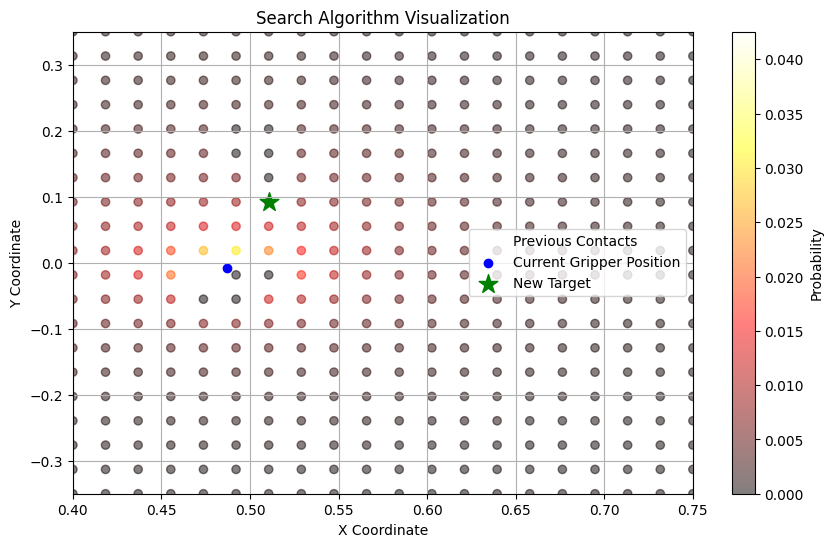

[0.5105263157894737, 0.05526315789473685, -0.0020952269367315885]


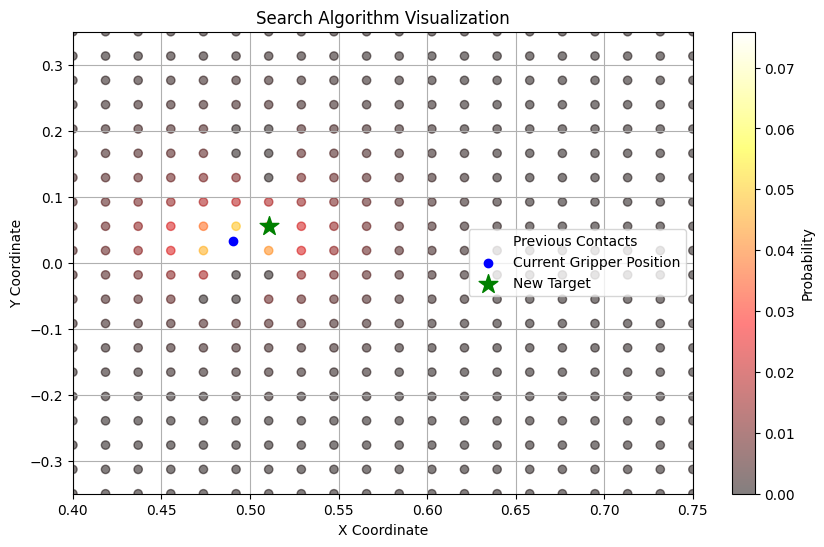

[0.4736842105263158, 0.1289473684210526, -0.0020952269367315885]


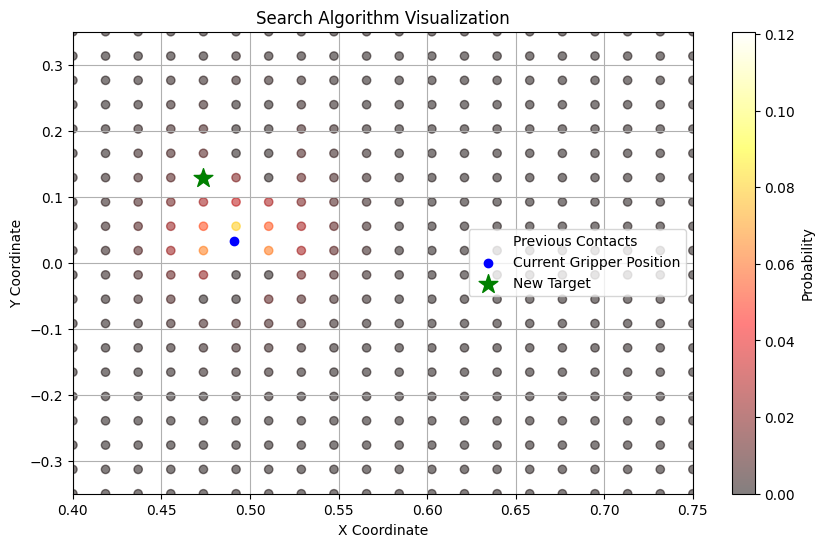

[0.4736842105263158, 0.1657894736842105, -0.0020952269367315885]


KeyboardInterrupt: 

In [9]:
def run_search(station, frame = "hand_root", object_bias=None):
    plant = station.GetSubsystemByName("plant")
    # Get initial pose of the gripper by using default context of manip station.
    gripper = plant.GetBodyByName(frame)
    plant_context = plant.GetMyContextFromRoot(context)

    X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)
    table_end_effector_poses = contact.get_table_contact(X_WG)
    p_WG_post = table_end_effector_poses[-1].translation()
       
    obj_touched, new_contacts = motion_planning.move_arm(p_WG_post, simulator, station, context, time_interval=0.4, frame=frame)
    
    if obj_touched == "table":
        table_height = min(new_contacts[:, 2])
        touched_point = new_contacts[np.random.choice(np.arange(len(new_contacts)))]
        print("Table height: ", table_height)
    else:
        print("Table not found")
        # NOTE: Here we should feed coordinates into search algorithm

    all_touched_points = set()
    for point in new_contacts:
        all_touched_points.add(tuple(point))

    i = 0
    while obj_touched == "table":
        #reset_arm(station, simulator, context, x0)
        if i > 30:
            break
        i += 1
        
        object_bias = search.update_target_bias(all_touched_points, object_bias)
        next_touch, weights = search.sample_new_target(touched_point, all_touched_points, target_bias=object_bias)
        next_point = [next_touch[0], next_touch[1], table_height]
        X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)

        print(next_point)
        # NOTE: This can change if there's biases in the search algorithm, based on the object's height and expected distance from the gripper
        # NOTE: We might also modify it based on some energy constraint, to minimize movement costs
        arc_height = 0.25 
        obj_touched, new_contacts = motion_planning.move_arm(next_point, simulator, station, context, time_interval=0.4, frame=frame)
        for point in new_contacts:
            all_touched_points.add(tuple(point))

        fig = visualizations.plot_2d_search(X_WG.translation(), all_touched_points, next_touch, object_bias, p_W_brick)
        plt.show()

    print("Object found! Location at: ", next_touch)
    print("Actual object location: ", p_W_brick)
    print("Difference: ", np.linalg.norm(np.array(next_touch) - np.array(p_W_brick[:2])))

run_search(station, object_bias = [p_W_brick[0], p_W_brick[1], 0.25, 0.25])

